In [6]:
from swebench_utils import build_swebench_images
from datasets import load_dataset

DATASET_ID = "princeton-nlp/SWE-bench_Lite"
SPLIT = "test"
INSTANCE_ID = "astropy__astropy-7746"
RUN_ID = "v0"

# base -> environment -> instance images
build_swebench_images(
    DATASET_ID, SPLIT,
    instance_ids=[INSTANCE_ID],
    tag="latest"
)

dataset = load_dataset(DATASET_ID, split=SPLIT)
instance_details = [r for r in dataset if r["instance_id"] == INSTANCE_ID][0]

Base image sweb.base.py.x86_64:latest already exists, skipping build.
Base images built successfully.
No environment images need to be built.
Building instance images for 1 instances


1 ran successfully, 0 failed: 100%|██████████| 1/1 [00:00<00:00, 258.21it/s]

All instance images built successfully.


In [7]:
# create environment
from environment import Environment
from swebench.harness.test_spec.test_spec import make_test_spec
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

test_spec = make_test_spec(instance_details)
env = Environment.from_test_spec(
    test_spec=test_spec,
    run_id=RUN_ID,
)

from editor import Editor

code_editor = Editor(env)

01:18:04,62 environment INFO Running container: sweb.eval.astropy__astropy-7746.v0


2025-01-20 01:18:04,062 - environment - INFO - Running container: sweb.eval.astropy__astropy-7746.v0


STATUS
created


In [8]:
env.container.remove(force=True)

In [6]:
# test failed linter
print(code_editor.edit_file("foos.py", start_line=1, end_line=1, new_content="import io\nprint(io.__version__)"))

File foos.py created successfully.


2025-01-19 17:17:09,152 - botocore.credentials - INFO - Found credentials from IAM Role: Test-EC2-S3-FullAccess


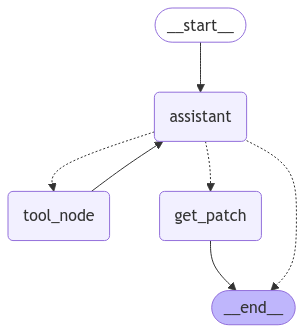

In [ ]:
from langchain_aws import ChatBedrockConverse
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image
import prompt_templates as pt
from dotenv import load_dotenv
from botocore.config import Config
from typing import Annotated, List
import operator


load_dotenv("../.env")

llm = ChatBedrockConverse(
    model="us.anthropic.claude-3-5-sonnet-20240620-v1:0",
    # credentials_profile_name="ediewald+1111-Admin",
    config=Config(
        retries={"max_attempts": 100}
    ),
    region_name="us-east-1",
)

def submit():
    """Submit your changes once complete."""
    return env.get_patch()

tools = [
    code_editor.open_file,
    code_editor.scroll_up,
    code_editor.scroll_down,
    code_editor.ls,
    code_editor.search_files,
    code_editor.code_search,
    code_editor.edit_file,
    code_editor.run_python_file,
    code_editor.execute_command,
    code_editor.rm,
    submit
]

llm_with_tools = llm.bind_tools(tools)

class CodeReviewerState(MessagesState):
    patch: str
    trajectory: Annotated[List[str], operator.add]

def assistant(state: CodeReviewerState):
    # todo: collapse messages efficiently - e.g. remove failed tool calls
    next_message = llm_with_tools.invoke([pt.AGENT_INSTRUCTIONS] + state["messages"])
    return {
        "messages": [next_message],
        "trajectory": [next_message.pretty_print()]
    }
    
def get_patch(state: CodeReviewerState):
    patch = env.get_patch()
    return {"patch": patch}

def route_messages(state: CodeReviewerState):
    last_message = state["messages"][-1]
    if last_message and "submit" in [t.get("name") for t in last_message.tool_calls]:
        return "get_patch"  # Route to end
    else:
        return "tool_node"  # Route back to tool node
    
workflow = StateGraph(CodeReviewerState)

workflow.add_node("assistant", assistant)
workflow.add_node("tool_node", ToolNode(tools))
workflow.add_node("get_patch", get_patch)

# Define edges: these determine how the control flow moves
workflow.add_edge(START, "assistant")
workflow.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    route_messages,
)
workflow.add_edge("tool_node", "assistant")
workflow.add_edge("get_patch", END)
graph = workflow.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage

# code_editor.reset()

messages = [HumanMessage(content=pt.START_AGENT.format(
    repo=instance_details["repo"],
    problem_statement=instance_details["problem_statement"],
))]
# Start conversation
model_patch = None
for chunk in graph.stream({"messages": messages}, stream_mode="updates"):
    if "tool_node" in chunk:
        chunk["tool_node"]["messages"][-1].pretty_print()
    elif "assistant" in chunk:
        chunk["assistant"]["messages"][-1].pretty_print()
    elif "get_patch" in chunk:
        model_patch = chunk["get_patch"]["patch"]

if model_patch:
    print("GOT MODEL PATCH")
    print(model_patch)

================================== Ai Message ==================================

[{'type': 'text', 'text': "Certainly! I'll go through the process step-by-step to resolve this issue. Let's begin with reproducing the issue.\n\n1. REPRODUCE_ISSUE:\nFirst, I'll create a file to reproduce the issue."}, {'type': 'tool_use', 'name': 'edit_file', 'input': {'file_path': 'reproduce_issue.py', 'start_line': 1, 'end_line': 1, 'new_content': 'import pytest\n\n@pytest.mark.skip\ndef test_skip_location() -> None:\n    assert 0\n\nif __name__ == "__main__":\n    import sys\n    sys.exit(pytest.main([__file__, "-rs", "--runxfail"]))'}, 'id': 'tooluse_of1MB9rAR0Km50i4euAwqQ'}]
Tool Calls:
  edit_file (tooluse_of1MB9rAR0Km50i4euAwqQ)
 Call ID: tooluse_of1MB9rAR0Km50i4euAwqQ
  Args:
    file_path: reproduce_issue.py
    start_line: 1
    end_line: 1
    new_content: import pytest

@pytest.mark.skip
def test_skip_location() -> None:
    assert 0

if __name__ == "__main__":
    import sys
    sys.exit(pyt

KeyboardInterrupt: 

In [7]:
chunk

{'tool_node': {'messages': [ToolMessage(content='============================= test session starts ==============================\nplatform linux -- Python 3.9.21, pytest-5.4.1.dev593+ge6e300e72, py-1.11.0, pluggy-0.13.1\nrootdir: /testbed, configfile: pyproject.toml\ncollected 1 item\n\nreproduce_issue.py s                                                     [100%]\n\n=========================== short test summary info ============================\nSKIPPED [1] src/_pytest/skipping.py:239: unconditional skip\n============================== 1 skipped in 0.01s ==============================\n\n', name='run_python_file', id='e006d661-c8dc-4523-9d99-bdc084da02b6', tool_call_id='tooluse_XVc0ArrgRje1lB_70AakHQ')]}}

In [9]:
env.execute_command("grep -Irn MediaOrderConflictWarning django/forms")

'django/forms/widgets.py:36:class MediaOrderConflictWarning(RuntimeWarning):\ndjango/forms/widgets.py:145:                        MediaOrderConflictWarning,\n'